## Loading of Steinmetz data

includes some visualizations

In [4]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [5]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
alldat[6]['spks'].shape

(584, 252, 250)

"alldat" contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. The mouse had to determine which side has the highest contrast. For each dat = alldat[k], you have the following fields:

* dat['spks']: neurons by trials by time bins. Time bin = 10ms.   
* dat['brain_area']: brain area for each neuron recorded. 
* dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* dat['contrast_left']: contrast level for left stimulus. 
* dat['response']: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.  
* dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and always does!). 
* dat['wheel']: exact position of the wheel that the mice uses to make a response, binned at 10ms. 
* dat['pupil']: pupil area  (noisy, because pupil is very small). 
* dat['lfp']: recording of the local field potential in each brain area from this experiment, binned at 10ms.
* dat['brain_area_lfp']: brain area names for the LFP channels. 




In [7]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [8]:
print(np.min(dat['response_time']))

0.47941449767444055


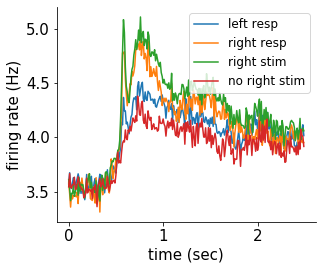

In [9]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [10]:
#@title groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
               ]

# not in this animals (but in others on figshare)
#  ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
#  ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
#  ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate

NN = len(dat['brain_area']) # number of neurons
barea = len(brain_groups) * np.ones(NN, ) # last one is "other"
for j in range(len(brain_groups)):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
print(len(barea[barea == 0]))

145


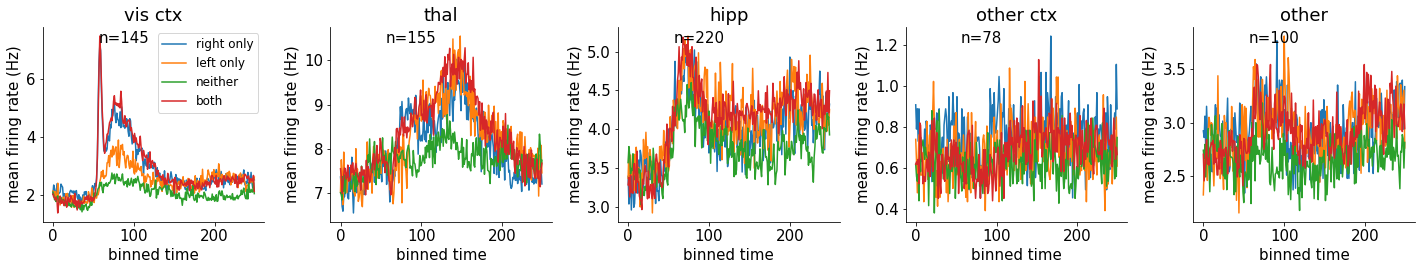

In [11]:
#@title plots by brain region and visual conditions
for j in range(len(brain_groups)+1):
    ax = plt.subplot(1,len(brain_groups)+1,j+1)
    plt.title(regions[j])
  
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
    if j==0:
        plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right>0].mean(axis=(0,1)))
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right==0].mean(axis=(0,1)))

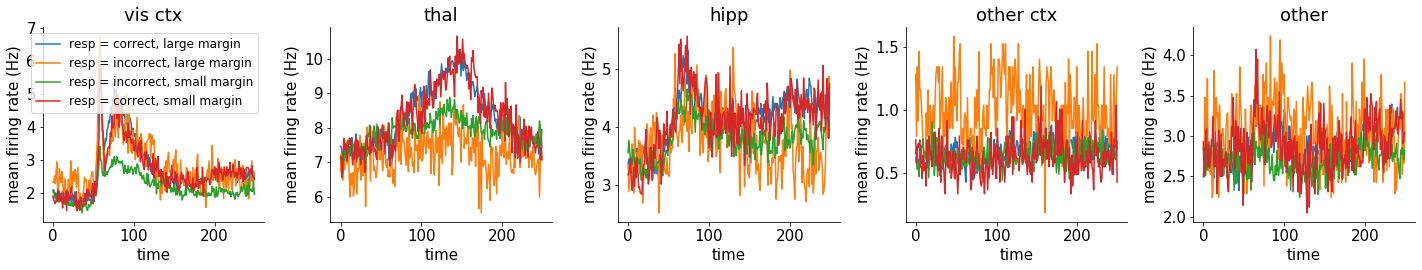

In [12]:
#@title plots by brain region and response type
is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0,
                            np.sign(vis_left - vis_right) != 0)
is_large_margin = np.abs(vis_left-vis_right) >= 0.5
for j in range(len(brain_groups)+1):
    ax = plt.subplot(1,len(brain_groups)+1,j+1)
    plt.title(regions[j])
    if np.sum(barea==j)==0:
        continue
    plt.plot(1/dt * dat['spks'][barea==j][:,np.logical_and(is_correct, is_large_margin)].mean(axis=(0,1)))  
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(~is_correct, is_large_margin)].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(~is_correct, ~is_large_margin)].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(is_correct, ~is_large_margin)].mean(axis=(0,1)))
    #plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
    if j==0:
        plt.legend(['resp = correct, large margin', 'resp = incorrect, large margin', 'resp = incorrect, small margin', 'resp = correct, small margin'], fontsize=12)
    ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')
  #print(np.abs(vis_left-vis_right))


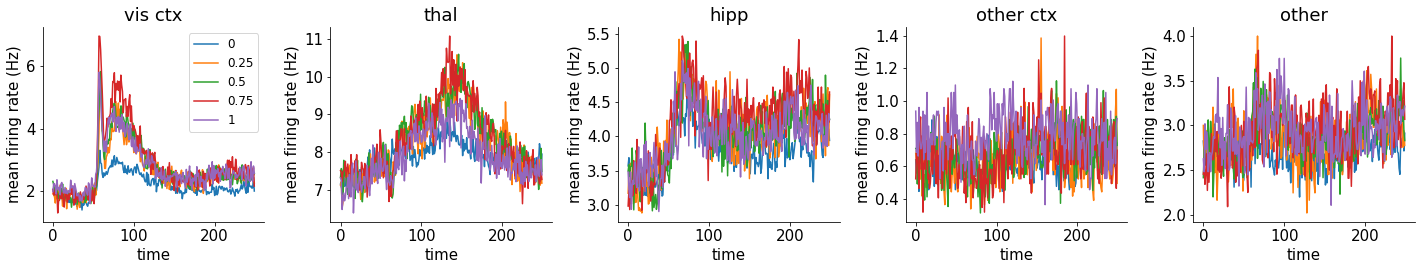

In [13]:
for j in range(len(brain_groups)+1):
    ax = plt.subplot(1,len(brain_groups)+1,j+1)
    plt.title(regions[j])
    if np.sum(barea==j)==0:
        continue
    plt.plot(1/dt * dat['spks'][barea==j][:,np.abs(vis_left - vis_right) == 0].mean(axis=(0,1)))  
    plt.plot(1/dt * dat['spks'][barea==j][:, np.abs(vis_left - vis_right) == 0.25].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.abs(vis_left - vis_right) == 0.5].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.abs(vis_left - vis_right) == 0.75].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:, np.abs(vis_left - vis_right) == 1].mean(axis=(0,1)))

    #plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
    if j==0:
        plt.legend(['0','0.25','0.5','0.75','1'], fontsize=12)
    ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')

In [14]:

import copy

def smooth_dat(dat):
    """ Given a session of data: dat
        return the smoothed data, which is the firing rate for each recorded neuron
        by convolving the raw spikes counts data with a 1d gaussian filter
    Args:
    dat(dict): one session of data
    Return:
    dat_rate (dict): a deep copy of input data, with its raw spike counts data replaced
    by the spking rate data after convoling
    """
    # define a gaussian kernel (mu=0, sigma=1)
    x = np.arange(-1, 1, 0.1)
    gaussian = 1/np.sqrt(2*np.pi)* np.exp(-x ** 2 /2.)
    dat_smoothed = copy.deepcopy(dat)
    for i in range(dat_smoothed['spks'].shape[0]):
        for j in range(dat_smoothed['spks'].shape[1]):
            spks = copy.deepcopy(dat['spks'][i][j])
            dat_smoothed['spks'][i][j] = np.convolve(spks, gaussian, 'same')

    return dat_smoothed

In [15]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
#TODO: factor out neurons that are in root?
from sklearn.decomposition import PCA, SparsePCA
import pandas as pd

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = SparsePCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))
W = pd.DataFrame(W).T
W['brain_area'] = dat['brain_area']


In [16]:
smoothed = smooth_dat(dat)

droll_sm = np.reshape(smoothed['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll_sm = droll_sm - np.mean(droll_sm, axis=1)[:, np.newaxis]
model_sm = PCA(n_components = 5).fit(droll_sm.T)
W_sm = model_sm.components_
pc_sm_10ms = W_sm @ np.reshape(smoothed['spks'], (NN,-1))
pc_sm_10ms = np.reshape(pc_sm_10ms, (5, -1, NT))
W_sm = pd.DataFrame(W_sm).T
W_sm['brain_area'] = dat['brain_area']

In [55]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(pd.DataFrame(W.T))
    print(W['brain_area' != 'root'].shape)


(697,)


0       True
1       True
2      False
3       True
4      False
       ...  
692     True
693     True
694     True
695     True
696    False
Length: 697, dtype: bool

DG       LGd      root       ACA      VISp        LH       CA1  \
0 -0.322507  0.189633  0.419331 -0.002070  1.490581 -0.229140  0.193044   
1 -1.030642  0.033349 -0.074904  0.010539 -0.310356  0.764178 -0.039956   
2 -0.183588 -0.069692 -0.131855 -0.011471  1.869279  0.273005 -0.180590   
3  0.665501  0.055093  0.000017  0.012699  1.193726 -0.492458 -0.060940   
4 -0.509811 -0.035292 -0.153928  0.000775  0.278489 -0.891080 -0.253216   

         PL       MOs       SUB        MD     VISam  
0 -0.026469  0.001064  1.723306  1.506077  1.192584  
1 -0.009917 -0.000875  0.171822  2.293465  0.194756  
2 -0.035322 -0.000134 -1.243390  0.559856 -0.758301  
3  0.039380  0.002978  0.267194 -1.621307  0.629776  
4  0.032321  0.000323 -0.959469  1.510997 -0.328878  


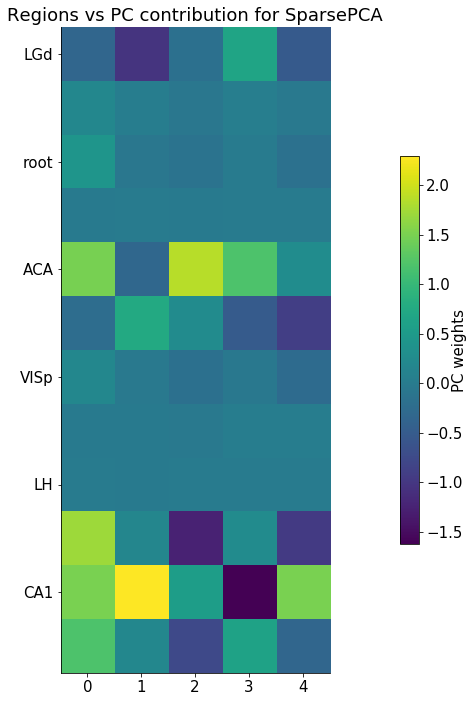

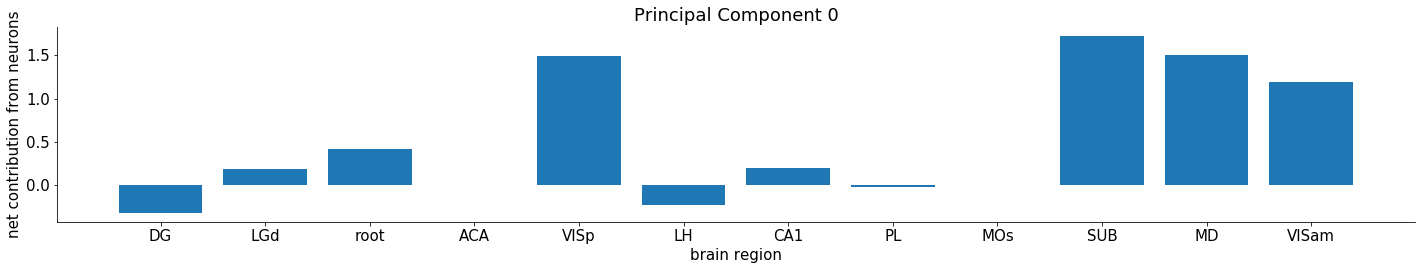

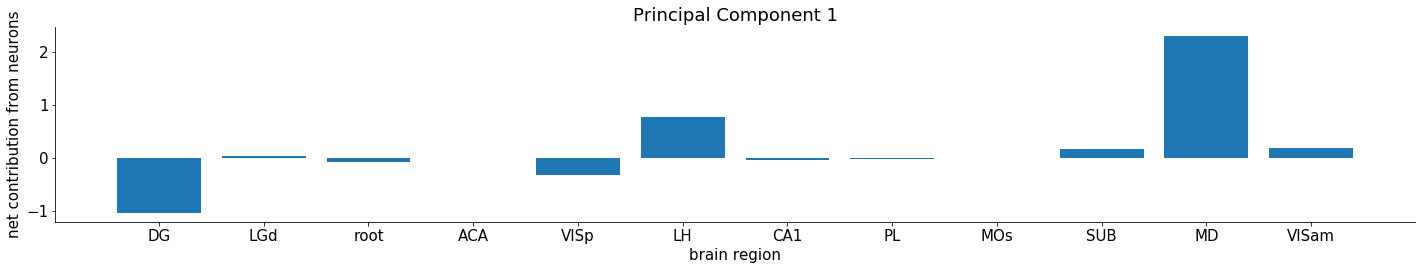

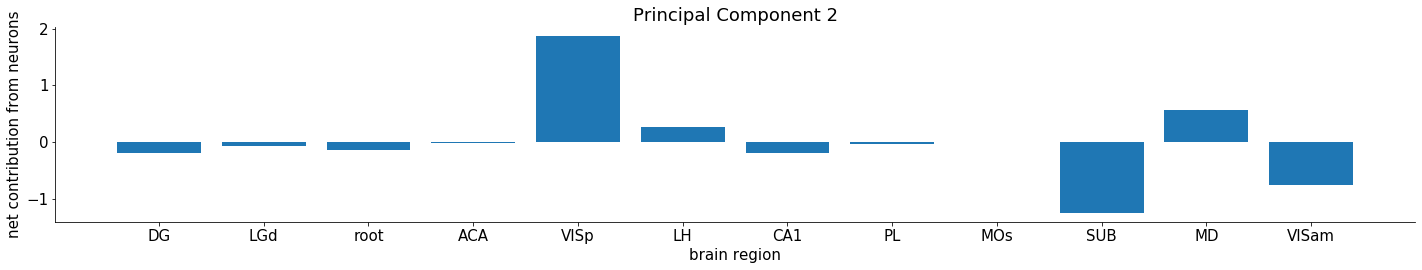

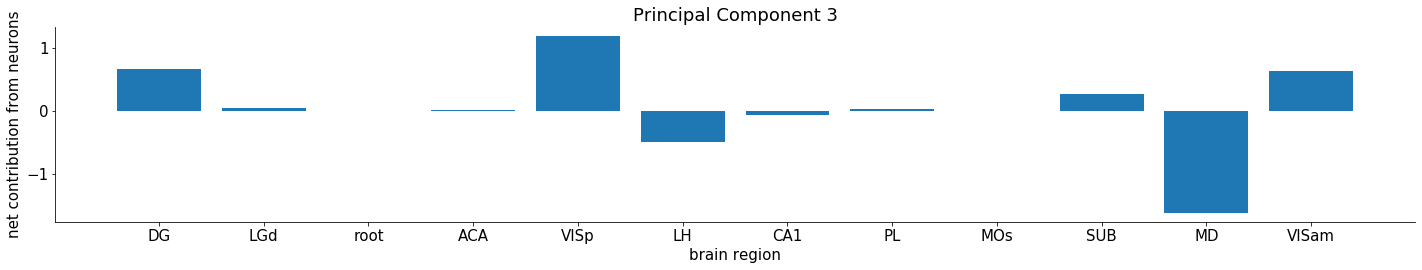

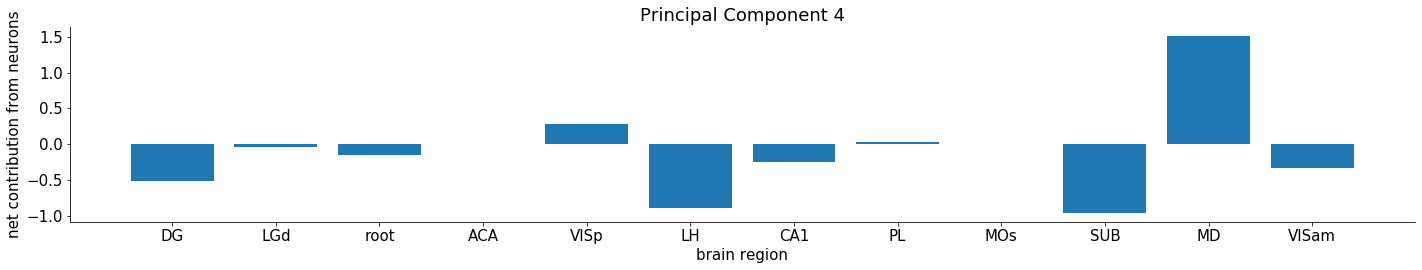

In [18]:

W.sort_values(by = ['brain_area'])
areas = set(W['brain_area'].to_list())
#average principal component values by each brain region to see how they contribute
#but also need to factor out zeros
W_nozeros = W.iloc[W.index[W.sum(axis = 1) != 0]]
avg_area_pcs = {}
for area in areas:
    if area in list(W_nozeros['brain_area']):
        avg_area_pcs[area] = W_nozeros.iloc[np.where(W_nozeros['brain_area'] == area)].sum(axis = 0)[:5]
    else:
        avg_area_pcs[area] = pd.Series([0.0] * 5)
avg_area_pcs = pd.DataFrame(avg_area_pcs, dtype = float)
print(avg_area_pcs)
fig, axs = plt.subplots(1,1,figsize = (20,10))
im = axs.imshow(avg_area_pcs.T)
axs.set_yticklabels(avg_area_pcs.columns)
axs.set_title("Regions vs PC contribution for SparsePCA")
clb = fig.colorbar(im, ax=axs, shrink = 0.6)
clb.ax.set_ylabel('PC weights', va='bottom')
for row in range(5):
    plt.figure()
    plt.title("Principal Component " + str(row))
    plt.bar(list(avg_area_pcs.columns),avg_area_pcs.iloc[row])
    plt.xlabel('brain region')
    plt.ylabel('net contribution from neurons')


In [19]:
x = pc_10ms[:,is_large_margin]
is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0,
                            np.sign(vis_left - vis_right) != 0)
is_large_margin = np.abs(vis_left-vis_right) >= 0.25
y = is_correct[is_large_margin]
x = x.reshape(x.shape[1],x.shape[0],x.shape[2])
print(np.shape(dat['spks']))
print(np.sum(is_correct[~is_large_margin]))
#with 1 sess, 5 principal components there are 5x250 features, 214 data points for large margin: this is bad

(698, 340, 250)
0


Text(0.5, 1.0, 'PC 4')

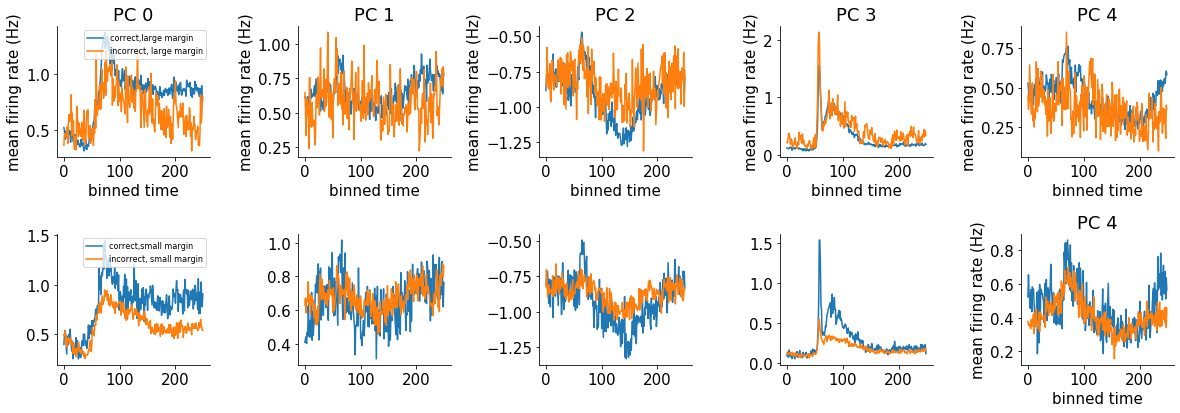

In [31]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    ax = plt.subplot(2,len(pc_10ms)+1,j+1)
    pc1 = pc_10ms[j]

    plt.plot(pc1[np.logical_and(is_correct,is_large_margin), :].mean(axis=0))  
    plt.plot(pc1[np.logical_and(~is_correct,is_large_margin), :].mean(axis=0))
    #plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
    #plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
    if j==0:
        plt.legend(['correct,large margin', 'incorrect, large margin', 'neither', 'both'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
    plt.plot(pc1[np.logical_and(is_correct,~is_large_margin), :].mean(axis=0))  
    plt.plot(pc1[np.logical_and(~is_correct,~is_large_margin), :].mean(axis=0))
    #plt.plot(pc1[response==0, :].mean(axis=0))

    if j==0:
        plt.legend(['correct,small margin', 'incorrect, small margin', 'neither', 'both'], fontsize=8)
ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
plt.title('PC %d'%j)

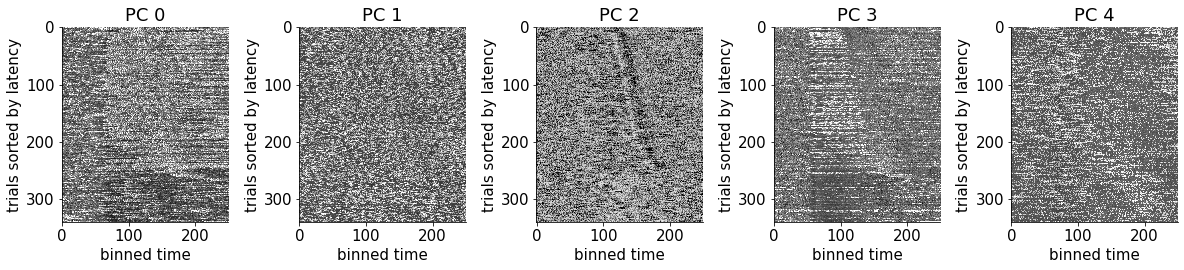

In [32]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

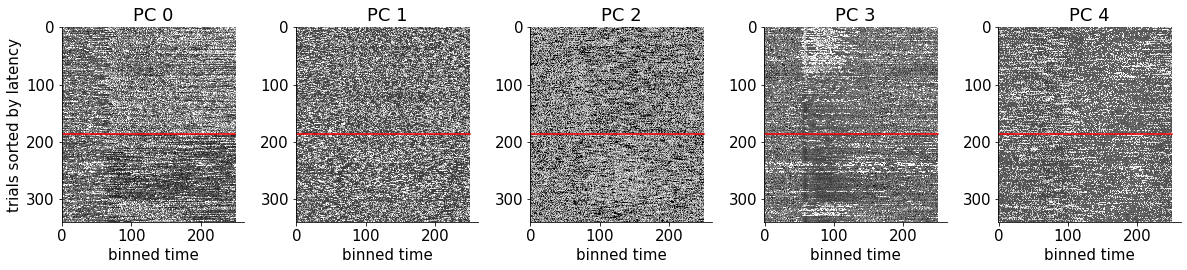

In [33]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0,
                            np.sign(vis_left - vis_right) != 0)
# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


[Text(0, 0.5, 'pupil area'),
 Text(0.5, 0, 'binned time'),
 Text(0.5, 1.0, 'Incorrect Pupil dynamics')]

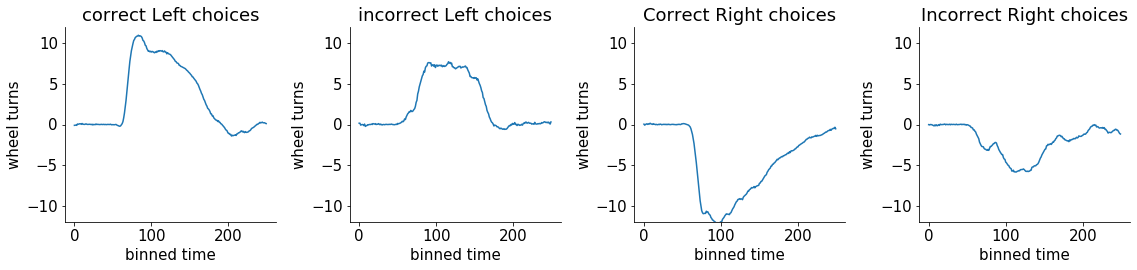

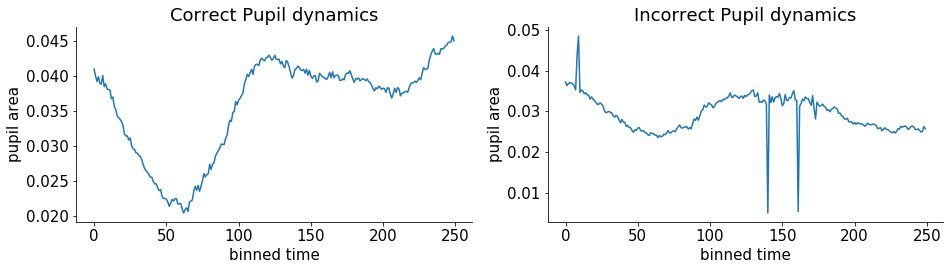

In [42]:
# plot the behavioral data (pupil area is noisy because it's very small)
is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0)
yl = [-12, 12]
ax = plt.subplot(1,5,1)
plt.plot(dat['wheel'][0,np.logical_and(is_correct, response>0)].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='correct Left choices');

ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0,np.logical_and(~is_correct, response>0)].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='incorrect Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0,np.logical_and(is_correct, response<0)].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Correct Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0,np.logical_and(~is_correct, response<0)].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Incorrect Right choices');

plt.figure()
ax = plt.subplot(1,3,1)
plt.plot(dat['pupil'][0, is_correct].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Correct Pupil dynamics')
ax = plt.subplot(1,3,2)
plt.plot(dat['pupil'][0, ~is_correct].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Incorrect Pupil dynamics')



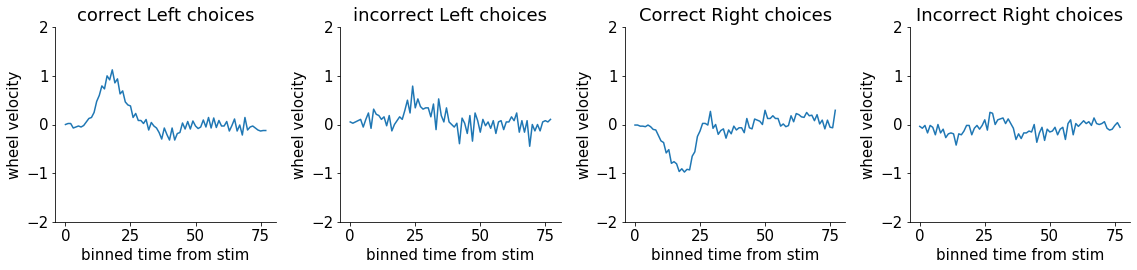

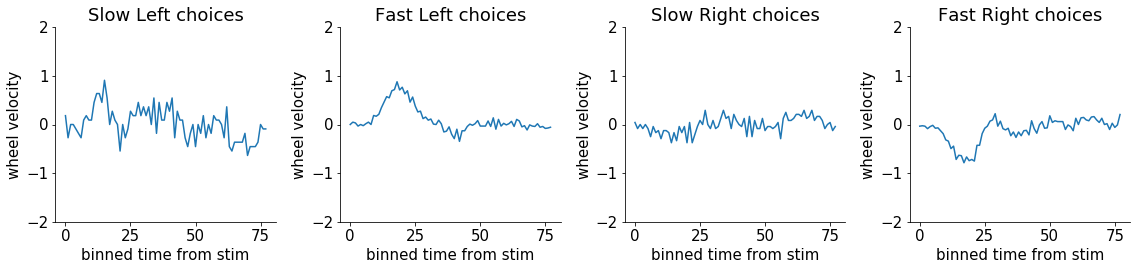

In [43]:
# plot the behavioral data (pupil area is noisy because it's very small)
is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0)
d = dat['wheel'][0,:,51:130]
yl = [-2, 2]
ax = plt.subplot(1,5,1)
plt.plot(np.diff(d[np.logical_and(is_correct, response>0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='correct Left choices');

ax = plt.subplot(1,5,2)
plt.plot(np.diff(d[np.logical_and(~is_correct, response>0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='incorrect Left choices');

ax = plt.subplot(1,5,3)
plt.plot(np.diff(d[np.logical_and(is_correct, response<0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='Correct Right choices');

ax = plt.subplot(1,5,4)
plt.plot(np.diff(d[np.logical_and(~is_correct, response<0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='Incorrect Right choices');

plt.figure()
# plot the behavioral data (pupil area is noisy because it's very small)
slow_resp = dat['response_time'] > np.mean(dat['response_time'])
slow_resp.squeeze()
slow_resp = slow_resp.reshape(slow_resp.shape[0])
yl = [-2, 2]
ax = plt.subplot(1,5,1)
plt.plot(np.diff(d[np.logical_and(slow_resp, response>0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='Slow Left choices');

ax = plt.subplot(1,5,2)
plt.plot(np.diff(d[np.logical_and(~slow_resp, response>0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='Fast Left choices');

ax = plt.subplot(1,5,3)
plt.plot(np.diff(d[np.logical_and(slow_resp, response<0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='Slow Right choices');

ax = plt.subplot(1,5,4)
plt.plot(np.diff(d[np.logical_and(~slow_resp, response<0)].mean(0)))
ax.set(ylim=yl, ylabel='wheel velocity', xlabel = 'binned time from stim', title='Fast Right choices');





Text(0.5, 1.0, 'PC 4')

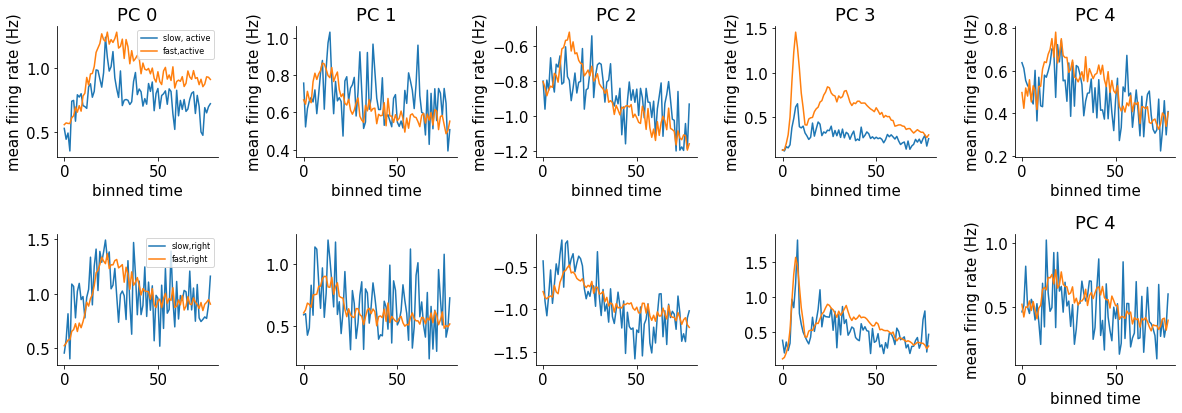

In [44]:
slow_resp = dat['response_time'] > np.mean(dat['response_time'])
slow_resp.squeeze()
slow_resp = slow_resp.reshape(slow_resp.shape[0])
slow_resp.shape
is_large_margin = np.abs(vis_left - vis_right) > 0.49
is_correct = np.logical_and(np.sign(response)==np.sign(vis_left-vis_right),response != 0, np.sign(vis_left - vis_right) != 0)        
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j][:,51:130]

  #plt.plot(pc1[np.logical_and(slow_resp,~is_correct), :].mean(axis=0))  
  #plt.plot(pc1[np.logical_and(~slow_resp,~is_correct), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(slow_resp, response !=0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(~slow_resp, response !=0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['slow, active', 'fast,active'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[np.logical_and(slow_resp, is_correct), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(~slow_resp, is_correct ), :].mean(axis=0))

  if j==0:
    plt.legend(['slow,right', 'fast,right'], fontsize=8)
ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
plt.title('PC %d'%j)

[[67 57]
 [32 92]]


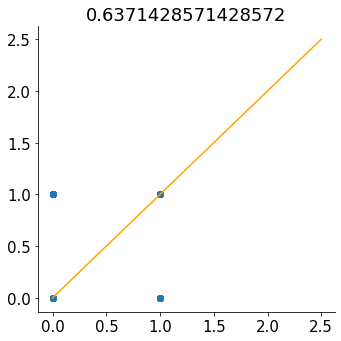

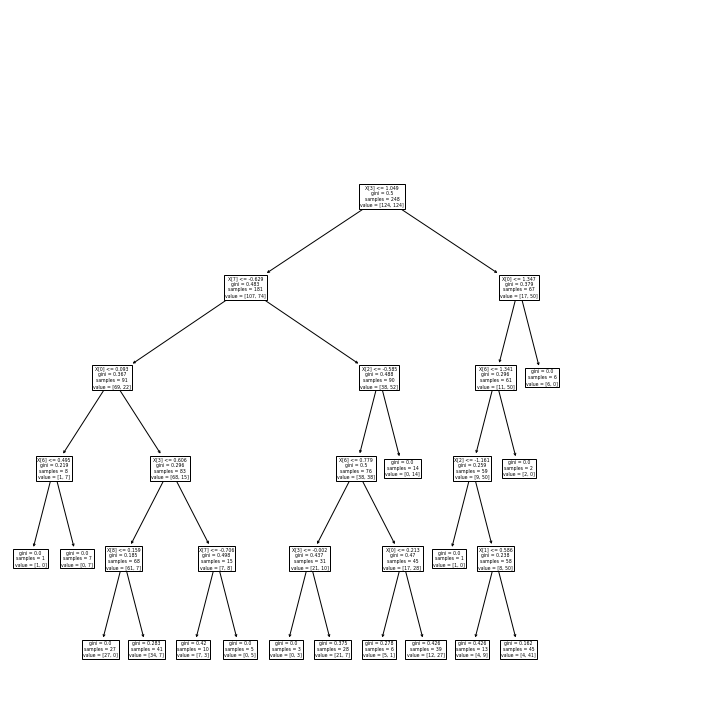

In [45]:
from sklearn.utils import resample
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix


time = pd.DataFrame(dat['response_time'][response != 0])
y = np.array(slow_resp[response != 0],dtype = int)
#if selecting correct vs incorrect, need to subtract 1 so the incorrect class is 1, correct is 0 . 
# #This way upsampling works on class 1, the smaller one
y = 1 - np.array(is_correct[response != 0], dtype = int)

#if trying to predict whether the stimulus was large vs small
y = np.array(is_large_margin[response != 0], dtype = int)
#print(dat['response_time'][response !=0])
pc = pc_10ms[:,response!=0,:]
#take the mean individually so that we can use different size windows for each dim
x = np.concatenate([pc[:,:,51:60].mean(axis = 2),pc[:,:,60:70].mean(axis = 2)])
#x = pc[:,:,51:65].mean(axis = 2)
dim = x.shape[0]

#x = np.mean(x, axis = 2)
d = np.vstack([x,y]).T

df = pd.DataFrame(d)
df.columns = [*range(1,x.shape[0]+1),'y']
df_slow = resample(df[df['y'] == 1.0],replace = True, n_samples = np.sum(df['y'] == 0.0),random_state = 1)
df = pd.concat([df_slow,df[df['y'] == 0.0]])


x = np.array([df[i] for i in range(1,dim)]).T
y = np.array([df['y']]).T
#rtmodel = LinearRegression()
#rtmodel = LogisticRegression(penalty = 'l1', C = 1, solver = 'saga', max_iter = 300)
rtmodel = DT(max_depth = 5)
pred = cross_val_predict(rtmodel, x, y)
plt.figure(figsize = (5,5))
plt.scatter(y,pred)
plt.plot(np.arange(0,3,0.5),np.arange(0,3,0.5),color = 'orange')
score = cross_val_score(rtmodel,x,y)
plt.title(score.mean())

print(confusion_matrix(y.squeeze(),pred,labels = [0,1]))
clf = rtmodel.fit(x,y)
plt.figure(figsize = (10,10))
plot_tree(clf)
plt.show()

Text(0, 0.5, '% accuracy')

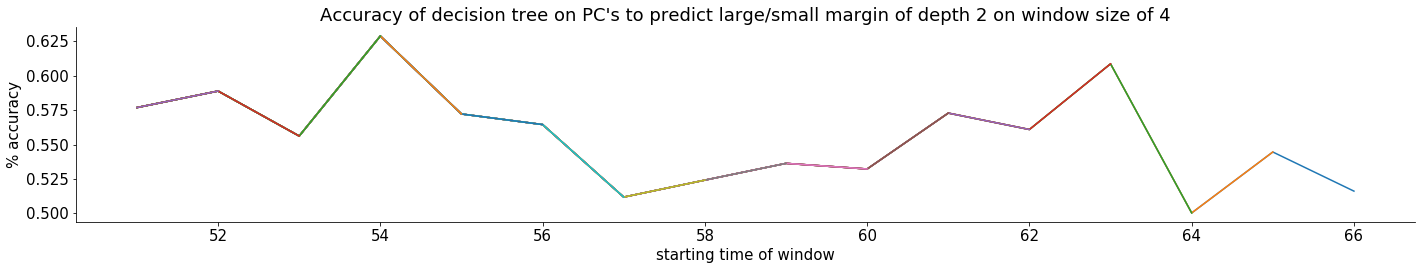

In [47]:
#Plotting accuracy of a decision tree over windows
accs = []
windowsize = 4
depth = 2
start, stop = 51, 71 - windowsize
y = np.array(slow_resp[response != 0],dtype = int)
#y = 1 - np.array(is_correct[response != 0], dtype = int)
y = np.array(is_large_margin[response != 0], dtype = int)

for i in range(start, stop):
    rowaccs = []
    for j in range(i, stop):
        x = pc[:,:,i:i+windowsize].mean(axis = 2)
        dim = x.shape[0]
        #x = np.mean(x, axis = 2)
        d = np.vstack([x,y]).T

        df = pd.DataFrame(d)
        df.columns = [*range(1,x.shape[0]+1),'y']
        df_slow = resample(df[df['y'] == 1.0],replace = True, n_samples = np.sum(df['y'] == 0.0),random_state = 1)
        df = pd.concat([df_slow,df[df['y'] == 0.0]])
        x = np.array([df[i] for i in range(1,dim)]).T
        y_new = np.array([df['y']]).T
        #rtmodel = LinearRegression()
        #rtmodel = LogisticRegression(penalty = 'l1', C = 10, solver = 'saga', max_iter = 300)
        rtmodel = DT(max_depth = depth )
        score = cross_val_score(rtmodel,x,y_new)
        rowaccs.append(score.mean())
    accs.append(rowaccs)

accs = pd.DataFrame(accs)
accs[accs == np.NaN] = 0
plt.plot(np.arange(51,71-windowsize),accs)
plt.title(f"Accuracy of decision tree on PC's to predict large/small margin of depth {depth} on window size of {windowsize}")
plt.xlabel("starting time of window")
plt.ylabel("% accuracy")

In [142]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=accs.values, x= np.arange(start,stop+1), y = np.arange(start,stop+1))])
fig.show()
